# **Giới thiệu**

**PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU VIDEO TRENDING TIKTOK BẰNG GOOGLE COLAB**

Nhóm tiến hành phân tích, thống kê, trực quan hóa trên tập dữ liệu đã được định dạng. Các file local mà nhóm sử dụng cần đính kèm là:
1. data_tiktok_10days.json
2. tiktok.jpg
3. vietnamese-stopwords.txt

Dưới đây là source code nhóm đã thực hiện

# **Phần 1: Hiển thị cấu trúc dữ liệu dạng DataFrame**

Cài đặt thư viện

In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots

Đọc file

In [4]:
file = open('data_tiktok_10days.json', encoding="utf8")
raw_data = json.load(file)
file.close()

len(raw_data['collector'])

1000

Hiển thị cấu trúc dạng DataFrame

In [5]:
trending_videos_list = raw_data['collector']

In [6]:
df_tiktok_dataset = pd.DataFrame(trending_videos_list)
df_tiktok_dataset

,id,text,createTime,authorMeta,musicMeta,covers,webVideoUrl,videoUrl,videoMeta,diggCount,shareCount,playCount,commentCount,hashtags
0,6950151666976951557,Follow my YouTube channel #foodqood,1618208297,"{'id': '6812963291129562118', 'secUid': 'MS4wL...","{'musicId': '6669854674113317638', 'musicName'...",{'default': 'https://p16-sign-va.tiktokcdn.com...,https://v16.tiktokcdn.com/1d8262c43ce9c8ad1706...,https://v16.tiktokcdn.com/1d8262c43ce9c8ad1706...,"{'height': 1024, 'width': 576, 'duration': 13}",4600000,319000,63500000,24300,[foodqood]
1,6958464277044792577,🤪,1620143720,"{'id': '6626092899037134849', 'secUid': 'MS4wL...","{'musicId': '6586947002464996102', 'musicName'...",{'default': 'https://p16-sign-sg.tiktokcdn.com...,https://v9-vn.tiktokcdn.com/ea51f030882c5b6d54...,https://v9-vn.tiktokcdn.com/ea51f030882c5b6d54...,"{'height': 540, 'width': 960, 'duration': 11}",6349,40,254600,59,[]
2,6957312513742540033,Makeup đã giúp thăng hạng nhan sắc thế nào?#Ch...,1619875553,"{'id': '6924800214197240833', 'secUid': 'MS4wL...","{'musicId': '6777243018756884481', 'musicName'...",{'default': 'https://p16-sign-sg.tiktokcdn.com...,https://v9-vn.tiktokcdn.com/bfe5c3b81e38c7616b...,https://v9-vn.tiktokcdn.com/bfe5c3b81e38c7616b...,"{'height': 960, 'width': 540, 'duration': 95}",11000,52,268500,49,"[changminmakeup, goclamdep]"
3,6955841401103994118,Fratello la semplicità è sempre una buona scel...,1619533035,"{'id': '127905465618821121', 'secUid': 'MS4wLj...","{'musicId': '6955841269407042309', 'musicName'...",{'default': 'https://p16-sign-va.tiktokcdn.com...,https://v16.tiktokcdn.com/04c786e6c2ed7f92eba9...,https://v16.tiktokcdn.com/04c786e6c2ed7f92eba9...,"{'height': 1024, 'width': 576, 'duration': 28}",8300000,55500,77800000,60700,"[learnwithtiktok, learnfromkhabi]"
4,6949465089267289346,👆👆 Watch Full Video 👆👆 #experiment #VS #car ...,1618048432,"{'id': '6940526321517446149', 'secUid': 'MS4wL...","{'musicId': '6949465067868015361', 'musicName'...",{'default': 'https://p16-sign-sg.tiktokcdn.com...,https://v9-vn.tiktokcdn.com/37e738fd71678ea367...,https://v9-vn.tiktokcdn.com/37e738fd71678ea367...,"{'height': 1024, 'width': 576, 'duration': 28}",63600,86,1300000,185,"[experiment, vs, car, crunchy, crushing, crush..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6960521749687586053,"I have a treat today,please be happy,ok ?#gest...",1620622768,"{'id': '6960489852706767877', 'secUid': 'MS4wL...","{'musicId': '6960521396153764614', 'musicName'...",{'default': 'https://p16-sign-va.tiktokcdn.com...,https://v16.tiktokcdn.com/4514408fe4ab8ace967b...,https://v16.tiktokcdn.com/4514408fe4ab8ace967b...,"{'height': 1024, 'width': 576, 'duration': 23}",76000,1625,346100,703,"[gesture, gesturedance, dancer, happy]"
996,6957311085053545730,hỏi đáp tâm sự đi các bạn ơiiii Nhớ follow và ...,1619875220,"{'id': '6557557841481121794', 'secUid': 'MS4wL...","{'musicId': '6952836017820928770', 'musicName'...",{'default': 'https://p16-sign-sg.tiktokcdn.com...,https://v16.tiktokcdn.com/c060cf0719d3798d84ef...,https://v16.tiktokcdn.com/c060cf0719d3798d84ef...,"{'height': 1024, 'width': 576, 'duration': 30}",24400,54,458100,270,[]
997,6961390399755685121,Hành trình kiếm tìm nụ cười #fyp #tiktokvn #fo...,1620825010,"{'id': '6854977182419698689', 'secUid': 'MS4wL...","{'musicId': '6956990112127585029', 'musicName'...",{'default': 'https://p16-sign-sg.tiktokcdn.com...,https://v16.tiktokcdn.com/14aae0f6bb7e49b6e681...,https://v16.tiktokcdn.com/14aae0f6bb7e49b6e681...,"{'height': 960, 'width': 540, 'duration': 12}",55600,1475,679000,502,"[fyp, tiktokvn, foryou]"
998,6951366101380893957,Easy,1618491048,"{'id': '127905465618821121', 'secUid': 'MS4wLj...","{'musicId': '6951365854600776453', 'musicName'...",{'default': 'https://p16-sign-va.tiktokcdn.com...,https://v16.tiktokcdn.com/6aa3b2faf59289e48fad...,https://v16.tiktokcdn.com/6aa3b2faf59289e48fad...,"{'height': 1024, 'width': 576, 'duration': 25}",9400000,100800,89500000,66900,[]


In [7]:
def object_to_columns(dfRow, **kwargs):
    '''Function to expand cells containing dictionaries, to columns'''
    for column, prefix in kwargs.items():
        if isinstance(dfRow[column], dict):
            for key, value in dfRow[column].items():
                columnName = '{}.{}'.format(prefix, key)
                dfRow[columnName] = value
    return dfRow

# Mở rộng các ô nhất định chứa từ điển thành các cột
df_tiktok_dataset = df_tiktok_dataset.apply(object_to_columns, 
                            authorMeta='authorMeta',  
                            musicMeta='musicMeta',
                            covers='cover',
                            videoMeta='videoMeta', axis = 1)

# Xóa các cột ban đầu chứa từ điển gốc
df_tiktok_dataset = df_tiktok_dataset.drop(['authorMeta','musicMeta','covers','videoMeta'], axis = 1)
df_tiktok_dataset

,id,text,createTime,webVideoUrl,videoUrl,diggCount,shareCount,playCount,commentCount,hashtags,authorMeta.id,authorMeta.secUid,authorMeta.name,authorMeta.nickName,authorMeta.verified,authorMeta.signature,authorMeta.avatar,musicMeta.musicId,musicMeta.musicName,musicMeta.musicAuthor,musicMeta.musicOriginal,musicMeta.playUrl,musicMeta.coverThumb,musicMeta.coverMedium,musicMeta.coverLarge,cover.default,cover.origin,cover.dynamic,videoMeta.height,videoMeta.width,videoMeta.duration
0,6950151666976951557,Follow my YouTube channel #foodqood,1618208297,https://v16.tiktokcdn.com/1d8262c43ce9c8ad1706...,https://v16.tiktokcdn.com/1d8262c43ce9c8ad1706...,4600000,319000,63500000,24300,[foodqood],6812963291129562118,MS4wLjABAAAABbfY3StRRWK8JrS87MiPkgp9CulzWVnyke...,Khalid El Mahi,Khalid El Mahi,False,CEO of BISMILLAH\n🔴YouTube ➡️ foodqood,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,6669854674113317638,BREAKFAST CHALLENGE,Spence,False,https://sf16-ies-music-sg.tiktokcdn.com/obj/ti...,https://p9-sg.tiktokcdn.com/aweme/100x100/tos-...,https://p9-sg.tiktokcdn.com/aweme/200x200/tos-...,https://p9-sg.tiktokcdn.com/aweme/720x720/tos-...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,1024,576,13
1,6958464277044792577,🤪,1620143720,https://v9-vn.tiktokcdn.com/ea51f030882c5b6d54...,https://v9-vn.tiktokcdn.com/ea51f030882c5b6d54...,6349,40,254600,59,[],6626092899037134849,MS4wLjABAAAALR89pAaBQRmlNLvYP5r839aFKlLgREIXcV...,Trung Quang,Trung Quang,False,,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6586947002464996102,Oh No,Kreepa,False,https://sf9-ies-music-sg.tiktokcdn.com/obj/tik...,https://p9-sg.tiktokcdn.com/aweme/100x100/tos-...,https://p9-sg.tiktokcdn.com/aweme/200x200/tos-...,https://p9-sg.tiktokcdn.com/aweme/720x720/tos-...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,540,960,11
2,6957312513742540033,Makeup đã giúp thăng hạng nhan sắc thế nào?#Ch...,1619875553,https://v9-vn.tiktokcdn.com/bfe5c3b81e38c7616b...,https://v9-vn.tiktokcdn.com/bfe5c3b81e38c7616b...,11000,52,268500,49,"[changminmakeup, goclamdep]",6924800214197240833,MS4wLjABAAAA4Sg2sJphaJXN9vw79W63ZyCc-IJWTmgt6a...,Changminmakeup,Changminmakeup,False,For work👉 IG:Changminmakeup\nCác sản phẩm MAKE...,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6777243018756884481,Waiting For Heartache,BLVKSHP,False,https://sf9-ies-music-sg.tiktokcdn.com/obj/tik...,https://p9-sg.tiktokcdn.com/aweme/100x100/tikt...,https://p9-sg.tiktokcdn.com/aweme/200x200/tikt...,https://p9-sg.tiktokcdn.com/aweme/720x720/tikt...,https://p16-sign-sg.tiktokcdn.com/tos-alisg-p-...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,960,540,95
3,6955841401103994118,Fratello la semplicità è sempre una buona scel...,1619533035,https://v16.tiktokcdn.com/04c786e6c2ed7f92eba9...,https://v16.tiktokcdn.com/04c786e6c2ed7f92eba9...,8300000,55500,77800000,60700,"[learnwithtiktok, learnfromkhabi]",127905465618821121,MS4wLjABAAAAwAg0rSzO65WQfz4RzQgGv2Xdv108BgPXhR...,Khabane lame,Khabane lame,True,Se volete ridere siete nel posto giusto 😎🇸🇳🇮🇹,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,6955841269407042309,suono originale,Khabane lame,True,https://sf9-ies-music-va.tiktokcdn.com/obj/mus...,https://p77-sign-va.tiktokcdn.com/tos-maliva-a...,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,1024,576,28
4,6949465089267289346,👆👆 Watch Full Video 👆👆 #experiment #VS #car ...,1618048432,https://v9-vn.tiktokcdn.com/37e738fd71678ea367...,https://v9-vn.tiktokcdn.com/37e738fd71678ea367...,63600,86,1300000,185,"[experiment, vs, car, crunchy, crushing, crush...",6940526321517446149,MS4w

Trích xuất thông tin dữ liệu

In [8]:
df_tiktok_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       1000 non-null   object
 1   text                     1000 non-null   object
 2   createTime               1000 non-null   int64 
 3   webVideoUrl              1000 non-null   object
 4   videoUrl                 1000 non-null   object
 5   diggCount                1000 non-null   int64 
 6   shareCount               1000 non-null   int64 
 7   playCount                1000 non-null   int64 
 8   commentCount             1000 non-null   int64 
 9   hashtags                 1000 non-null   object
 10  authorMeta.id            1000 non-null   object
 11  authorMeta.secUid        1000 non-null   object
 12  authorMeta.name          1000 non-null   object
 13  authorMeta.nickName      1000 non-null   object
 14  authorMeta.verified      1000 non-null   

In [9]:
# Lấy các hàng duy nhất từ ​​tập dữ liệu
df_unique_videos = df_tiktok_dataset.drop_duplicates(subset='id', keep="first")
df_unique_music = df_tiktok_dataset.drop_duplicates(subset='musicMeta.musicId', keep="first")
df_unique_authors = df_tiktok_dataset.drop_duplicates(subset='authorMeta.id', keep="first")

# Hiển thị số lượng hàng trên mỗi tập
{
    'df_tiktok_dataset': df_tiktok_dataset.shape,
    'df_unique_videos': df_unique_videos.shape,
    'df_unique_music': df_unique_music.shape,
    'df_unique_authors': df_unique_authors.shape
}

{'df_tiktok_dataset': (1000, 31),
 'df_unique_authors': (506, 31),
 'df_unique_music': (529, 31),
 'df_unique_videos': (578, 31)}

# **Phần 2: Phân tích dữ liệu**

## **I. Phân tích dữ liệu trùng lặp**

Đếm dữ liệu trùng lặp

In [10]:
count_duplicated = pd.crosstab(index=df_tiktok_dataset['id'], columns='duplicates')
count_duplicated

col_0,duplicates
id,
6925559746128907526,1
6925773613698256133,1
6925866034490543366,1
6926508267598531845,2
6926583800365370629,3
...,...
6961642113620593922,1
6961664991611129090,1
6961702011028950273,1


Hiển thị 10 video có tần suất xuất hiện nhiều nhất

In [11]:
duplicated = pd.crosstab(index=[df_tiktok_dataset['id'],df_tiktok_dataset['text'], df_tiktok_dataset['authorMeta.name'], 
                                df_tiktok_dataset['authorMeta.verified'], df_tiktok_dataset['authorMeta.signature'],
                                df_tiktok_dataset['musicMeta.musicName']], columns='duplicates')
df_duplicate = duplicated.sort_values(by='duplicates', ascending=False)
df_duplicate.head(10)  

,,,,,col_0,duplicates
id,text,authorMeta.name,authorMeta.verified,authorMeta.signature,musicMeta.musicName,
6955841401103994118,Fratello la semplicità è sempre una buona scelta! 😉Bro simplicity is always a good choice! 😉 #LearnWithTikTok #LearnFromKhabi,Khabane lame,True,Se volete ridere siete nel posto giusto 😎🇸🇳🇮🇹,suono originale,8
6942051158437448962,Mẹ có thể đem lại hy vọng cứu rỗi cho cả những linh hồn tuyệt vọng nhất. #trang_sức_thiết_kế #xuhuongtiktok,trang sức gỗ giả đá phong thuỷ,False,Để đặt hàng nhanh nhất bấm dưới đây ⬇️,原聲 - 錄音吉娃娃,8
6937351021383388418,Hãy cảm nhận nó đang siết chặt #tips #tiktokphilippines #funnytiktok #viral_video #khoavegas #fypdongggggggg #aladintelecom #tutorials #PaperCut #wow,Khoa Vegas,False,Hello Everybody ♥️ I’m Vietnam\n🔹I wish you the happy video,오리지널 사운드 - Glass(유리),7
6944331615870995718,Easy breakfast sandwich 🥪!!! #рекомендации (via miaobianshishen|douyin),foodgod,True,My name was JONATHAN.. now it’s FOODGOD (legally),La Vie En Rose,7
6950151666976951557,Follow my YouTube channel #foodqood,Khalid El Mahi,False,CEO of BISMILLAH\n🔴YouTube ➡️ foodqood,BREAKFAST CHALLENGE,7
6957703300816981253,Non c’è bisogno di Didascalia😅——No Caption Needed.😅 #learnfromkhaby #LearnWithTikTok #ImparaConTikTok #nocaptionneeded,Khabane lame,True,Se volete ridere siete nel posto giusto 😎🇸🇳🇮🇹,suono originale,7
6935150455886564610,Cá mê rổ #fish #miềntây #interesting #tik_tok,Nguyễn Hạ Vi,False,,nhạc nền - Nguyễn Hạ Vi,7
6956939472286043397,Khabynho du Brazil 🇧🇷🤣Ritenta bro sarai più fortunato- Try again bro you be luckier next time.😜 #learnfromkhaby,Khabane lame,True,Se volete ridere siete nel posto giusto 😎🇸🇳🇮🇹,suono originale,7
6934205812751518977,#zodiacsigns #zodiac #virgo #fyp #chocolate,𝐉𝐞𝐧𝐧𝐲 𝐍𝐠𝐮𝐲𝐞𝐧,False,,original sound,7


## **II. Phân tích dữ liệu duy nhất**

### **1. Lọc dữ liệu duy nhất**

In [12]:
df_filter_dataset = df_tiktok_dataset.drop_duplicates(subset=['id'], keep='last')
df_filter_dataset

,id,text,createTime,webVideoUrl,videoUrl,diggCount,shareCount,playCount,commentCount,hashtags,authorMeta.id,authorMeta.secUid,authorMeta.name,authorMeta.nickName,authorMeta.verified,authorMeta.signature,authorMeta.avatar,musicMeta.musicId,musicMeta.musicName,musicMeta.musicAuthor,musicMeta.musicOriginal,musicMeta.playUrl,musicMeta.coverThumb,musicMeta.coverMedium,musicMeta.coverLarge,cover.default,cover.origin,cover.dynamic,videoMeta.height,videoMeta.width,videoMeta.duration
1,6958464277044792577,🤪,1620143720,https://v9-vn.tiktokcdn.com/ea51f030882c5b6d54...,https://v9-vn.tiktokcdn.com/ea51f030882c5b6d54...,6349,40,254600,59,[],6626092899037134849,MS4wLjABAAAALR89pAaBQRmlNLvYP5r839aFKlLgREIXcV...,Trung Quang,Trung Quang,False,,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6586947002464996102,Oh No,Kreepa,False,https://sf9-ies-music-sg.tiktokcdn.com/obj/tik...,https://p9-sg.tiktokcdn.com/aweme/100x100/tos-...,https://p9-sg.tiktokcdn.com/aweme/200x200/tos-...,https://p9-sg.tiktokcdn.com/aweme/720x720/tos-...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,540,960,11
8,6958387247888534785,Son môi xinh 💄💋,1620125784,https://v9-vn.tiktokcdn.com/b35f087a734bfb8877...,https://v9-vn.tiktokcdn.com/b35f087a734bfb8877...,10800,29,137800,41,[],6953575917210616833,MS4wLjABAAAAKirKyXhKYEKl1FYLp4r17Ts_QQbAqWdkn0...,Son Môi 💄,Son Môi 💄,False,Mua Hàng Vui Lòng Nhắn Tin Trực Tiếp ShOp,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6943561315130624770,Nụ Cười Thiên Thần Remix,Bean🇻🇳Knight,True,https://sf9-ies-music-sg.tiktokcdn.com/obj/tik...,https://p16-sign-sg.tiktokcdn.com/aweme/100x10...,https://p16-sign-sg.tiktokcdn.com/aweme/720x72...,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,960,544,11
12,6925773613698256133,Pure love#animals #lion,1612532346,https://v16.tiktokcdn.com/dd0c2c5f3960b5ce8d24...,https://v16.tiktokcdn.com/dd0c2c5f3960b5ce8d24...,30100000,770300,210200000,374400,"[animals, lion]",6900065928828224518,MS4wLjABAAAA6mvnQb3XgRB1gmg2hC754xsQ3la_4dNvfM...,user9225074089992,user9225074089992,False,Email:richardlee198803@gmail.com,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,222450148143108096,See You Again (feat. Charlie Puth),Wiz Khalifa,False,https://sf9-ies-music-sg.tiktokcdn.com/obj/ies...,https://p9-sg.tiktokcdn.com/aweme/100x100/tos-...,https://p9-sg.tiktokcdn.com/aweme/200x200/tos-...,https://p9-sg.tiktokcdn.com/aweme/720x720/tos-...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,https://p16-sign-va.tiktokcdn.com/obj/tos-mali...,1024,576,13
13,6954977915901660417,"Con dâu kho nhẹ 1 nồi cá mang về nội ăn, ông b...",1619331988,https://v9-vn.tiktokcdn.com/3284c113bcf6a53f94...,https://v9-vn.tiktokcdn.com/3284c113bcf6a53f94...,2854,13,82200,321,[nâunngoncungtiktok],66538775383,MS4wLjABAAAAIptVlh3I2Yy5IObJ9XaAsgDNUlw4BfNwxv...,Nguyễn Hà My,Nguyễn Hà My,False,FB Nguyễn Hà My( Tiệm nhà Bo),https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6954977915234749186,nhạc nền - Nguyễn Hà My,Nguyễn Hà My,True,https://sf16-ies-music-sg.tiktokcdn.com/obj/ti...,https://p16-sign-sg.tiktokcdn.com/aweme/100x10...,https://p16-sign-sg.tiktokcdn.com/aweme/720x72...,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,1024,576,17
14,6956157274800803073,Bạn sẽ chọn ai ..#ceotruongnguyen #hlvtruongng...,1619606578,https://v9-vn.tiktokcdn.com/60956c5c8dafde611f...,https://v9-vn.tiktokcdn.com/60956c5c8dafde611f...,5910,53,124000,196,"[ceotruongnguyen, hlvtruongnguyen, bandothanhc...",6946550081106396161,MS4wLjABAAAA0tYBm3JceJgjrSH_2AqG5WEOVK8OwXtab3...,CEO Trường Nguyễn,CEO Trường Nguyễn,False,"H

### **2. Hiển thị một số dữ liệu thống kê**

In [13]:
df_filter_dataset.describe()

,createTime,diggCount,shareCount,playCount,commentCount,videoMeta.height,videoMeta.width,videoMeta.duration
count,5.780000e+02,5.780000e+02,578.000000,5.780000e+02,578.000000,578.000000,578.000000,578.000000
mean,1.618587e+09,1.309351e+06,23205.332180,1.326312e+07,12170.013841,956.124567,581.214533,21.451557
std,2.129832e+06,3.914255e+06,75401.955162,3.163351e+07,41966.140486,138.180445,91.657030,17.744145
min,1.612483e+09,4.300000e+01,0.000000,2.999000e+03,0.000000,464.000000,320.000000,6.000000
25%,1.617410e+09,8.423000e+03,46.500000,1.533500e+05,90.250000,960.000000,540.000000,11.000000
50%,1.619376e+09,4.350000e+04,351.000000,6.411500e+05,447.000000,1024.000000,576.000000,15.000000
75%,1.620214e+09,6.466000e+05,13000.000000,1.000000e+07,4892.750000,1024.000000,576.000000,25.000000
max,1.620905e+09,3.330000e+07,930400.000000,2.214000e+08,417100.000000,1280.000000,1280.000000,155.000000


### **3. Biểu thị thời lượng video**

Text(0.5, 1.0, 'Video Length')

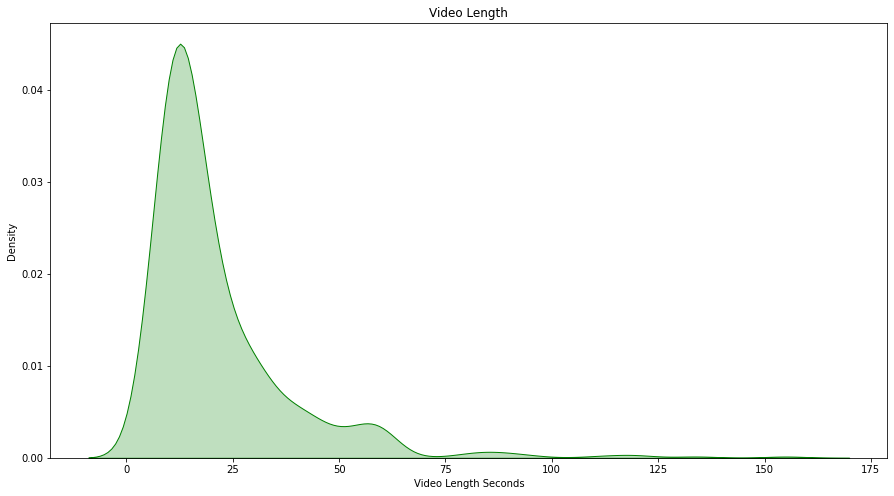

In [14]:
plt.figure(figsize=(15, 8))
sns.kdeplot(df_filter_dataset['videoMeta.duration'], fill=True, color='g')
plt.xlabel('Video Length Seconds')
plt.title('Video Length')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



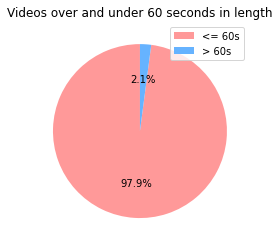

In [15]:
max_play=df_filter_dataset[df_filter_dataset['videoMeta.duration'] <= 60 ]['videoMeta.duration'].count() / df_filter_dataset['videoMeta.duration'].count() * 100
min_play=df_filter_dataset[df_filter_dataset['videoMeta.duration'] > 60 ]['videoMeta.duration'].count() / df_filter_dataset['videoMeta.duration'].count() * 100
df_views = df2 = pd.DataFrame([[max_play,min_play]], columns=['max_play','min_play'])

plt.pie(df_views, autopct='%0.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Videos over and under 60 seconds in length")
plt.legend(["<= 60s","> 60s"])

### **4. Biểu thị lượt play, like, share và comment theo từng khoảng**

Function trợ giúp về pandas cut()

In [16]:
# Wrapper around pandas cut() method.
def my_cut (x, bins, lower_infinite=False, upper_infinite=False, **kwargs):
    # Quick passthru if no infinite bounds
    if not lower_infinite and not upper_infinite:
        return pd.cut(x, bins, **kwargs)

    # Setup
    num_labels      = len(bins) - 1
    include_lowest  = kwargs.get("include_lowest", False)
    right           = kwargs.get("right", True)

    # Prepend/Append infinities where indiciated
    bins_final = bins.copy()
    if upper_infinite:
        bins_final.insert(len(bins),float("inf"))
        num_labels += 1
    if lower_infinite:
        bins_final.insert(0,float("-inf"))
        num_labels += 1

    # Decide all boundary symbols based on traditional cut() parameters
    symbol_lower  = "<=" if include_lowest and right else "<"
    left_bracket  = "(" if right else "["
    right_bracket = "]" if right else ")"
    symbol_upper  = ">" if right else ">="

    # Inner function reused in multiple clauses for labeling
    def make_label(i, lb=left_bracket, rb=right_bracket):
        return "{0} - {1}".format(bins_final[i], bins_final[i+1])

    # Create custom labels
    labels=[]
    for i in range(0,num_labels):
        new_label = None

        if i == 0:
            if lower_infinite:
                new_label = "{0} {1}".format(symbol_lower, bins_final[i+1])
            elif include_lowest:
                new_label = make_label(i, lb="[")
            else:
                new_label = make_label(i)
        elif upper_infinite and i == (num_labels - 1):
            new_label = "{0} {1}".format(symbol_upper, bins_final[i])
        else:
            new_label = make_label(i)

        labels.append(new_label)

    # Pass thru to pandas cut()
    return pd.cut(x, bins_final, labels=labels, **kwargs)

In [17]:
# Đặt khoảng
buckets = list(range(0,1200000,50000))
# Đếm số lượng video theo lượt like, share, comment, play theo từng khoảng
plays = df_filter_dataset.groupby( my_cut( df_filter_dataset['playCount'], buckets, upper_infinite=True ) ).diggCount.count()
likes = df_filter_dataset.groupby( my_cut( df_filter_dataset['diggCount'], buckets, upper_infinite=True ) ).diggCount.count()
plays = plays.rename('plays').to_frame().reset_index()
likes = likes.rename('likes').to_frame().reset_index()
fig = make_subplots(1,2,subplot_titles=("Distribution of Plays","Distribution of Likes"))
fig.add_trace(
    go.Bar(y = plays['playCount'], x = plays['plays'], name="Plays",text = plays['plays'], 
           orientation='h',texttemplate='%{text:.2s}', textposition='outside', marker_color='rgb(170, 210, 200)'
    ),
    row=1,col=1
)
fig.add_trace(
    go.Bar(y = likes['diggCount'], x = likes['likes'], name="Likes",text = likes['likes'], 
           orientation='h',texttemplate='%{text:.2s}', textposition='outside', marker_color='rgb(162, 210, 255)'
    ),
    row=1,col=2
)
fig.update_xaxes(title_text='Videos')
fig.update_yaxes(title_text='Plays', col=1, row=1, automargin=True)
fig.update_yaxes(title_text='Likes', col=2, row=1, automargin=True)
fig.show(config={'displayModeBar': False})

In [18]:
comments = df_filter_dataset.groupby( my_cut( df_filter_dataset['commentCount'], buckets, upper_infinite=True ) ).diggCount.count()
shares = df_filter_dataset.groupby( my_cut( df_filter_dataset['shareCount'], buckets, upper_infinite=True ) ).diggCount.count()


comments = comments.rename('comments').to_frame().reset_index() 
shares = shares.rename('shares').to_frame().reset_index() 
fig = make_subplots(1,2,subplot_titles=("Distribution of Comments", "Distribution of Shares"))


fig.add_trace(
    go.Bar(y = comments['commentCount'], x = comments['comments'], name="Comments",text = comments['comments'], 
           orientation='h',texttemplate='%{text:.2s}', textposition='outside', marker_color='rgb(205, 180, 219)'
    ),
    row=1,col=1
)
fig.add_trace(
    go.Bar(y = shares['shareCount'], x = shares['shares'], name="Shares",text = shares['shares'], 
           orientation='h',texttemplate='%{text:.2s}', textposition='outside', marker_color='rgb(154, 180, 200)'
    ),
    row=1,col=2
)
fig.update_xaxes(title_text='Videos')
fig.update_yaxes(title_text='Comments', col=1, row=1, automargin=True)
fig.update_yaxes(title_text='Share', col=2, row=1, automargin=True)
fig.show(config={'displayModeBar': False})

### **5. Biểu thị lượt play, like, share và comment trong một khoảng xác định**

**Biểu thị lượt play**

Text(0.5, 0, 'Plays')

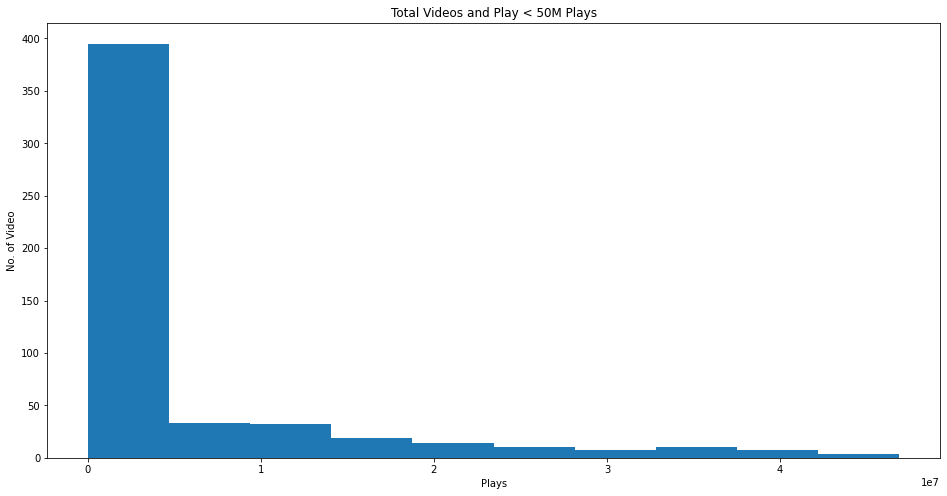

In [19]:
df_videos_users_focus = df_filter_dataset[df_filter_dataset['playCount'] <= 50000000 ]
ax = df_videos_users_focus['playCount'].plot(kind='hist', figsize=(16,8))
plt.title("Total Videos and Play < 50M Plays")
ax.set_ylabel('No. of Video')
ax.set_xlabel('Plays')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



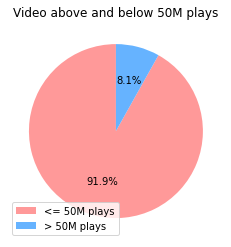

In [20]:
max_play=df_filter_dataset[df_filter_dataset['playCount'] <= 50000000 ]['playCount'].count() / df_filter_dataset['playCount'].count() * 100
min_play=df_filter_dataset[df_filter_dataset['playCount'] > 50000000 ]['playCount'].count() / df_filter_dataset['playCount'].count() * 100
df_views = df2 = pd.DataFrame([[max_play,min_play]], columns=['max_play','min_play'])

plt.pie(df_views, autopct='%0.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Video above and below 50M plays")
plt.legend(["<= 50M plays","> 50M plays"])

**Biểu thị lượt like**

Text(0.5, 0, 'Likes')

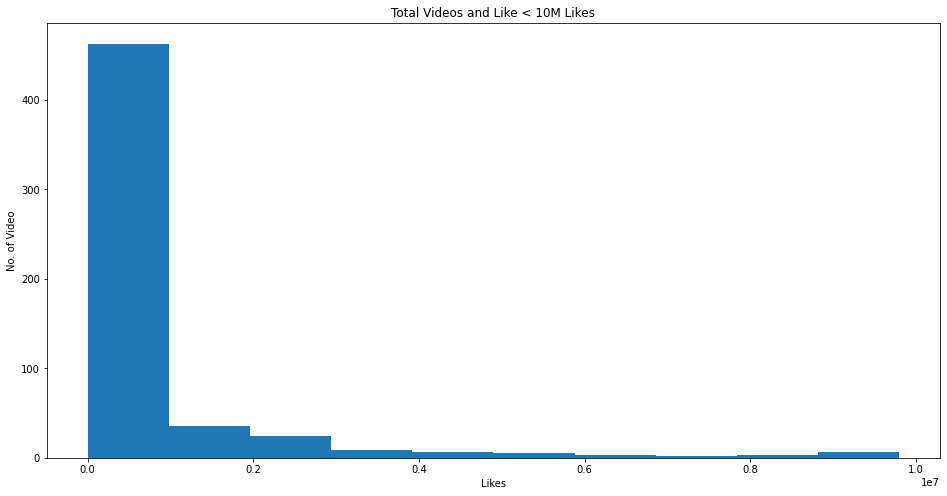

In [21]:
df_videos_users_focus = df_filter_dataset[df_filter_dataset['diggCount'] < 10000000 ]
ax = df_videos_users_focus['diggCount'].plot(kind='hist', figsize=(16,8))
plt.title("Total Videos and Like < 10M Likes")
ax.set_ylabel('No. of Video')
ax.set_xlabel('Likes')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



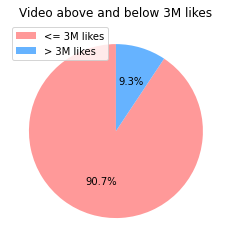

In [22]:
max_like=df_filter_dataset[df_filter_dataset['diggCount'] <= 3000000 ]['diggCount'].count() / df_filter_dataset['diggCount'].count() * 100
min_like=df_filter_dataset[df_filter_dataset['diggCount'] > 3000000 ]['diggCount'].count() / df_filter_dataset['diggCount'].count() * 100
df_views = df2 = pd.DataFrame([[max_like,min_like]], columns=['max_like','min_like'])

plt.pie(df_views, autopct='%0.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Video above and below 3M likes")
plt.legend(["<= 3M likes","> 3M likes"])

**Biểu thị lượt Share**

Text(0.5, 0, 'Shares')

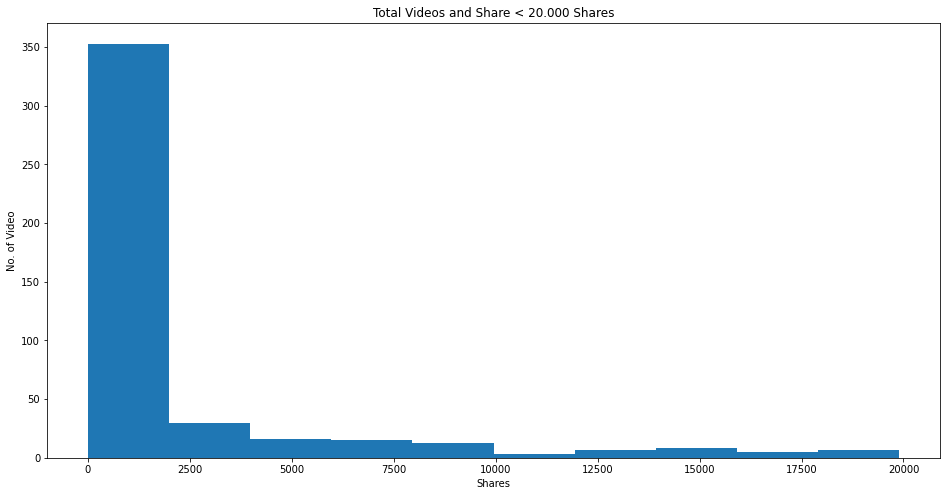

In [23]:
df_videos_users_focus_share = df_filter_dataset[df_filter_dataset['shareCount'] <= 20000 ]
ax = df_videos_users_focus_share['shareCount'].plot(kind='hist', figsize=(16,8))
plt.title("Total Videos and Share < 20.000 Shares")
ax.set_ylabel('No. of Video')
ax.set_xlabel('Shares')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



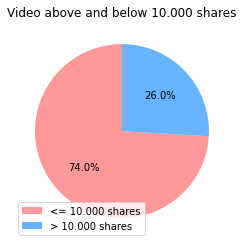

In [24]:
max_share=df_filter_dataset[df_filter_dataset['shareCount'] <= 10000 ]['shareCount'].count() / df_filter_dataset['shareCount'].count() * 100
min_share=df_filter_dataset[df_filter_dataset['shareCount'] > 10000 ]['shareCount'].count() / df_filter_dataset['shareCount'].count() * 100
df_views_share = df2_share = pd.DataFrame([[max_share,min_share]], columns=['max_share','min_share'])

plt.pie(df_views_share, autopct='%0.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Video above and below 10.000 shares")
plt.legend(["<= 10.000 shares","> 10.000 shares"])

**Biểu thị lượt comment**

Text(0.5, 0, 'Comments')

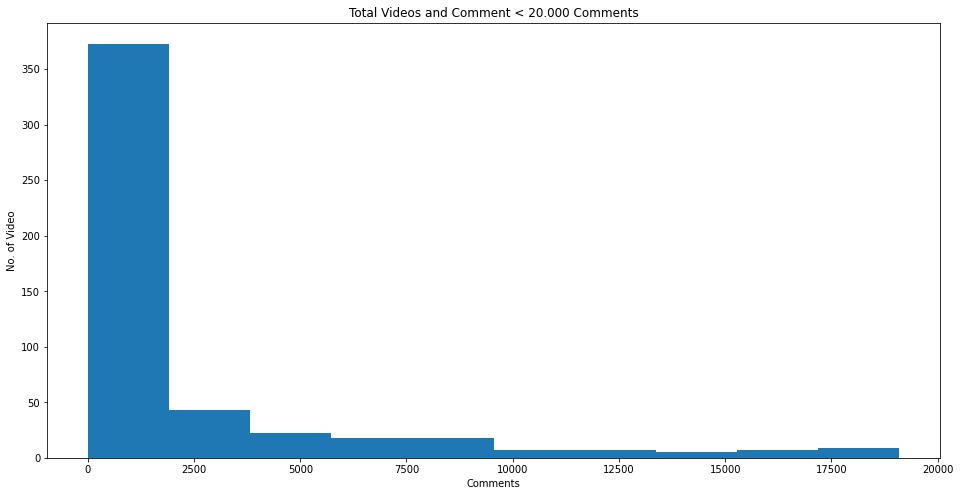

In [25]:
df_videos_users_focus_comment = df_filter_dataset[df_filter_dataset['commentCount'] <= 20000 ]
ax = df_videos_users_focus_comment['commentCount'].plot(kind='hist', figsize=(16,8))
plt.title("Total Videos and Comment < 20.000 Comments")
ax.set_ylabel('No. of Video')
ax.set_xlabel('Comments')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



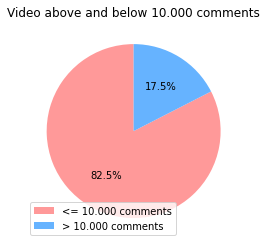

In [26]:
max_cmt=df_filter_dataset[df_filter_dataset['commentCount'] <= 10000 ]['commentCount'].count() / df_filter_dataset['commentCount'].count() * 100
min_cmt=df_filter_dataset[df_filter_dataset['commentCount'] > 10000 ]['commentCount'].count() / df_filter_dataset['commentCount'].count() * 100
df_views_cmt = df2_cmt = pd.DataFrame([[max_cmt,min_cmt]], columns=['max_cmt','min_cmt'])

plt.pie(df_views_cmt, autopct='%0.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Video above and below 10.000 comments")
plt.legend(["<= 10.000 comments","> 10.000 comments"])

### **6. Biểu thị sự tương quan giữa lượt like và comment**

In [27]:
# Tập trung vào những video trong tập dữ liệu nhỏ hơn 50.000 like
df_videos_users_focus = df_filter_dataset[df_filter_dataset['diggCount'] <= 50000]
# Tạo biểu đồ chấm với trend line
fig = px.scatter(df_videos_users_focus, trendline="ols",
                 x="diggCount", 
                 y="commentCount",
                 labels={
                     "diggCount": "Likes",
                     "commentCount": "Comments"
                 },
                 log_y=True,
                 trendline_color_override="#ff7096", 
                 template='plotly_white')

fig.update_traces(marker=dict(
                     color='#4cc9f0',
                     opacity=0.6,
                 ))
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### **7. Sự tương quan giữa các biến**

In [28]:
df_filter_dataset.corr()

,createTime,diggCount,shareCount,playCount,commentCount,authorMeta.verified,musicMeta.musicOriginal,videoMeta.height,videoMeta.width,videoMeta.duration
createTime,1.000000,-0.150225,-0.226837,-0.210498,-0.175782,-0.049582,0.094909,-0.171795,0.149447,0.005343
diggCount,-0.150225,1.000000,0.745343,0.950118,0.885260,0.479957,-0.020621,0.131781,-0.026998,0.006141
shareCount,-0.226837,0.745343,1.000000,0.760628,0.828396,0.204265,-0.094401,0.066558,-0.018979,-0.051402
playCount,-0.210498,0.950118,0.760628,1.000000,0.823016,0.501197,-0.056413,0.148011,-0.031897,-0.006981
commentCount,-0.175782,0.885260,0.828396,0.823016,1.000000,0.335596,-0.041439,0.099079,-0.019242,-0.023702
authorMeta.verified,-0.049582,0.479957,0.204265,0.501197,0.335596,1.000000,-0.055126,0.147526,-0.047453,-0.045596
musicMeta.musicOriginal,0.094909,-0.020621,-0.094401,-0.056413,-0.041439,-0.055126,1.000000,-0.020423,-0.044066,-0.016638
videoMeta.height,-0.171795,0.131781,0.066558,0.148011,0.099079,0.147526,-0.020423,1.000000,-0.532962,-0.009906
videoMeta.width,0.149447,-0.026998,-0.018979,-0.031897,-0.019242,-0.047453,-0.044066,-0.532962,1.000000,-0.011706
videoMeta.duration,0.005343,0.006141,-0.051402,-0.006981,-0.023702,-0.045596,-0.016638,-0.009906,-0.011706,1.000000


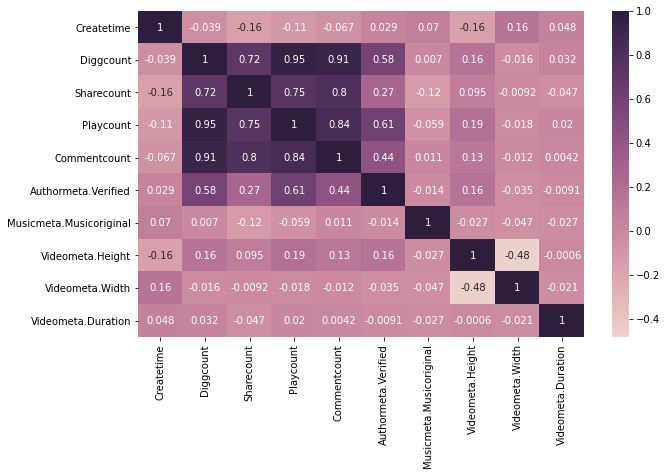

In [29]:
h_labels = [x.replace('_',' ').title() 
            for x in list(df_filter_dataset.select_dtypes(include=['number','bool']).columns.values)]
            
fig, ax = plt.subplots(figsize=(10,6))
_ =sns.heatmap(df_tiktok_dataset.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, 
               cmap=sns.cubehelix_palette(as_cmap=True), ax=None)

### **8. Người dùng nổi bật trên TikTok**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Username')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119829 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119842 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119838 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119853 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119820 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119858 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51060 missing from current font.

/usr/local/lib/python3.7/dist-packages/mat

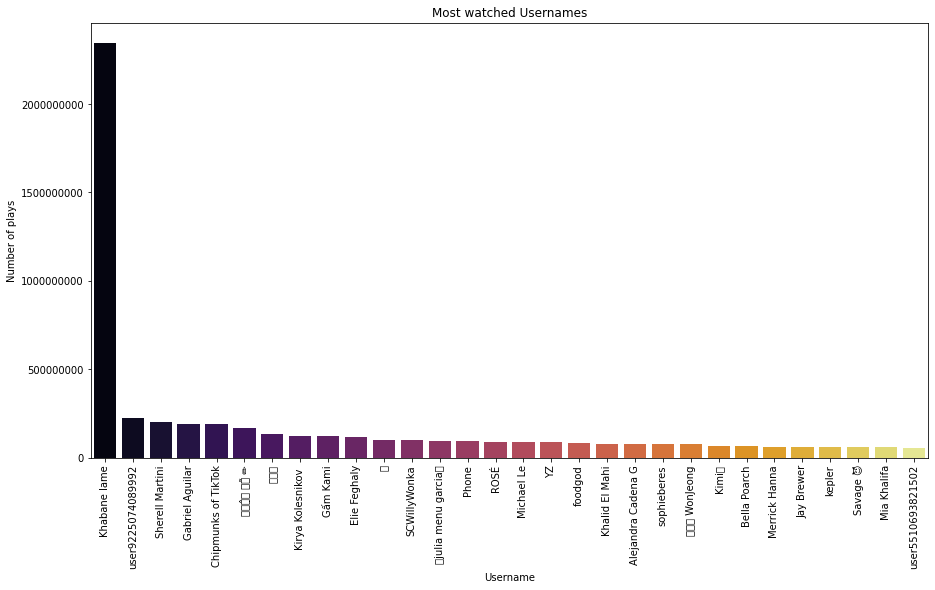

In [30]:
df_users = df_filter_dataset.groupby(['authorMeta.name']).sum()
pal = sns.color_palette("Blues", as_cmap=True)


df_users = df_users.sort_values(by='playCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most watched Usernames')
g = sns.barplot(df_users.index[:30], df_users.playCount[:30], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.ylabel('Number of plays')
plt.xlabel('Username')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Username')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119829 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119842 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119838 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119853 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119820 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119858 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51060 missing from current font.

/usr/local/lib/python3.7/dist-packages/mat

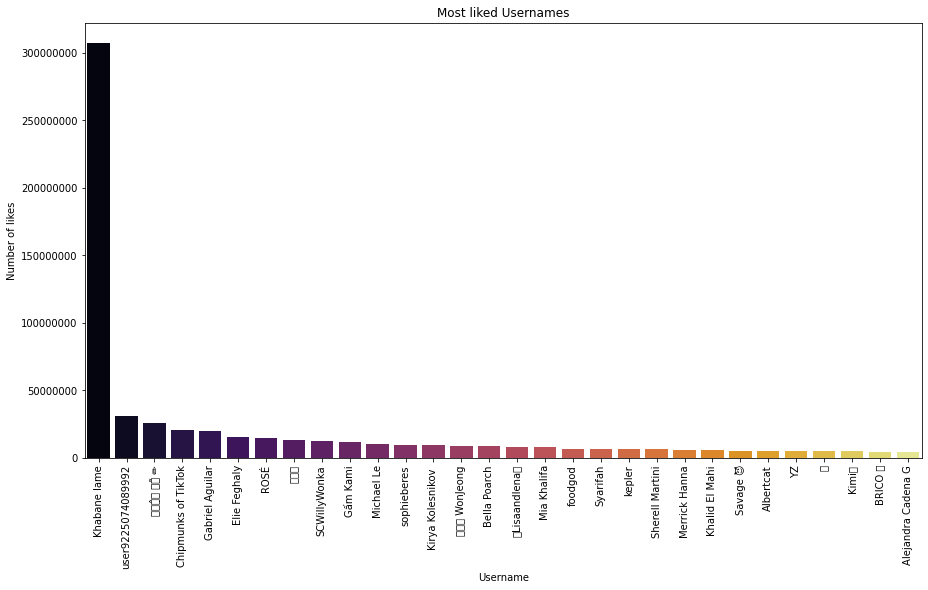

In [31]:
df_users = df_filter_dataset.groupby(['authorMeta.name']).sum()
pal = sns.color_palette("Blues", as_cmap=True)


df_users = df_users.sort_values(by='diggCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most liked Usernames')
g = sns.barplot(df_users.index[:30], df_users.diggCount[:30], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.ylabel('Number of likes')
plt.xlabel('Username')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Username')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119829 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119842 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119838 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119853 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119820 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 119858 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 50896 missing from current font.

/usr/local/lib/python3.7/dist-packages/mat

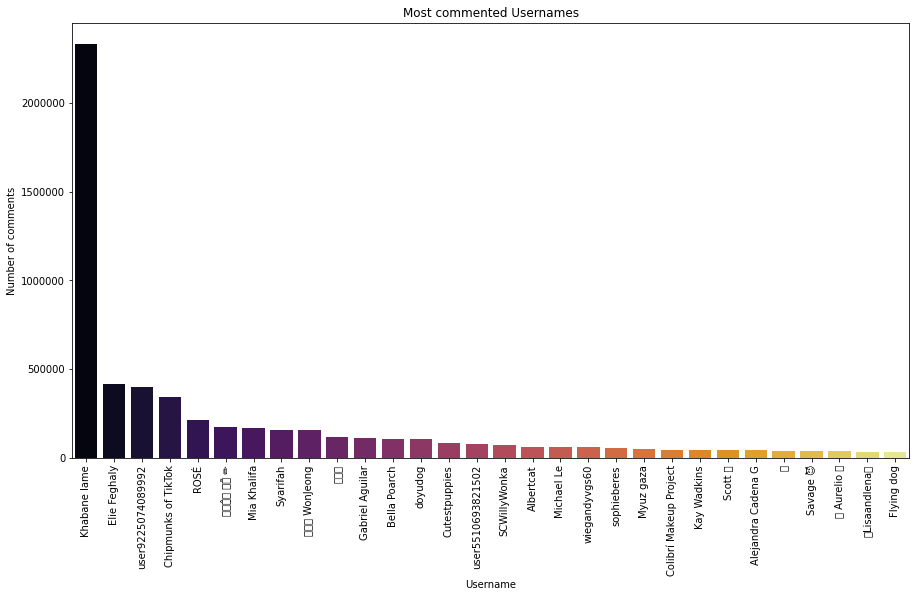

In [32]:
df_users = df_filter_dataset.groupby(['authorMeta.name']).sum()
pal = sns.color_palette("Blues", as_cmap=True)


df_users = df_users.sort_values(by='commentCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most commented Usernames')
g = sns.barplot(df_users.index[:30], df_users.commentCount[:30], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.ylabel('Number of comments')
plt.xlabel('Username')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Username')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128155 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 50896 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51221 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47592 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128054 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51060 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 49884 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplot

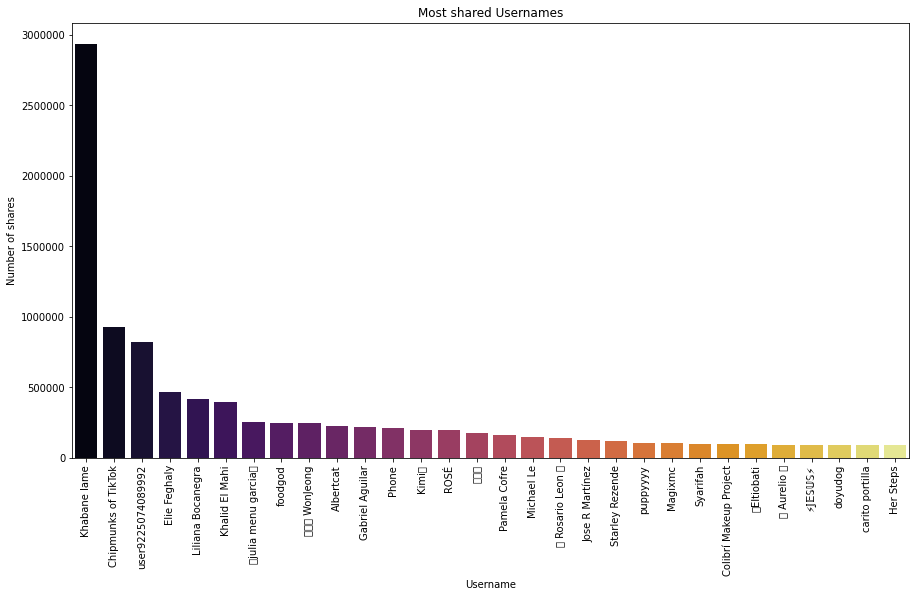

In [33]:
df_users = df_filter_dataset.groupby(['authorMeta.name']).sum()
pal = sns.color_palette("Blues", as_cmap=True)


df_users = df_users.sort_values(by='shareCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most shared Usernames')
g = sns.barplot(df_users.index[:30], df_users.shareCount[:30], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.ylabel('Number of shares')
plt.xlabel('Username')

### **9. Trích xuất dữ liệu Music Tiktok**

In [34]:
df_filter_dataset = pd.DataFrame(trending_videos_list)

In [35]:
df_filter_dataset = df_filter_dataset.apply(object_to_columns, 
                                        musicMeta='musicMeta', axis = 1)

In [36]:
musicMeta = df_filter_dataset[['musicMeta.musicName']]
musicMeta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   musicMeta.musicName  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


### **10. Trực quan dữ liệu nhạc Original**

In [37]:
# Thêm cột với giá trị mặc định
musicMeta ['count'] = 1

# Đếm tất cả nhạc, nhóm và thay thế giá trị cột đếm bằng tổng
musicMeta = musicMeta.groupby(["musicMeta.musicName"])["count"].count().reset_index()

# Sắp xếp theo các thẻ bắt đầu bằng # phổ biến nhất và giữ vị trí top 15
musicMeta = musicMeta.sort_values(by='count', ascending=False)[:15]

# Đặt màu

# Tạo Biểu đồ hình tròn với tất cả các giá trị
fig = go.Figure(data=[go.Pie(
                        labels=musicMeta["musicMeta.musicName"], 
                        values=musicMeta["count"], 
                        textinfo='label+percent',
                     
                )], 
                layout={"colorway": ["#6699FF","#FFFF66",
                                     "#FF99FF","#FFCC00",
                                     "#339966","#99FFCC",
                                     "#66CC00","#FFCCCC",
                                     "#FF9999","#CC00FF"]})
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
musicMeta.head(10)

,musicMeta.musicName,count
392,suono originale,78
366,original sound,66
383,original sound - Zemlak Jada,21
397,оригинальный звук,20
386,origineel geluid,14
9,Astronaut In The Ocean,13
150,nhạc nền,10
55,Lagi Tamvan,9
409,原聲 - 錄音吉娃娃,8
391,sonido original,8


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 21407 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 32882 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 37636 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 38899 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 21513 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 23043 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 21407 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotli

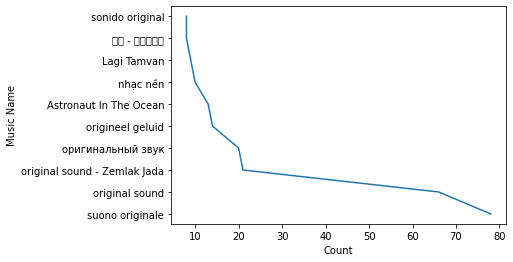

<Figure size 2160x720 with 0 Axes>

In [39]:
labels= musicMeta["musicMeta.musicName"].head(10)
values= musicMeta["count"].head(10)

plt.plot(values,labels)
plt.xlabel('Count')
plt.ylabel('Music Name')

plt.figure(figsize=(30,10))

plt.show()

### **11. Trực quan dữ liệu nhạc trên ứng dụng TikTok**

Thống kê dữ liệu

In [40]:
df_filter_dataset.groupby(['musicMeta.musicName']).describe().head(20)

createTime  ... commentCount
                                                        count  ...          max
musicMeta.musicName                                            ...             
 Lên Xe Đi Em Ơi #2                                     1.0  ...        434.0
 Một Ngày Là Anh Em Suốt Đời Là Anh Em...        1.0  ...         34.0
......Wiii                                                1.0  ...      24500.0
1 Điếu _Bay Phòng 888                                     6.0  ...        131.0
10,000 Hours                                              1.0  ...      22100.0
34+35 - Instrumental                                      1.0  ...        179.0
Amityville Horror - Scary Halloween Sound Effects         1.0  ...         64.0
Anh Muốn Đưa Em Về Không (DJ Đại Mèo Remix)               7.0  ...        423.0
Anh Muốn Đưa Em Về Không?                                 1.0  ...         28.0
Astronaut In The Ocean                                   13.0  ...      16800.0
Astronomia                                                2.0  ...          0.0
BOOM                                                      1.0  ...        112.0
BREAKFAST CHALLENGE                                       7.0  ...      29900.0
BUILD A BITCH BY BELLA POARCH                             4.0  ...      27200.0
Baby Shark                                                1.0  ...         14.0
Backyard Boy                                              1.0  ...        127.0
Bang Bang Bang                                            1.0  ...         14.0
Believer                                                  1.0  ...        309.0
Body (Remix) [feat. ArrDee, E1 (3x3), ZT (3x3),...        1.0  ...      18500.0
Bongo cha-cha-cha - Remastered                            2.0  ...         21.0

[20 rows x 40 columns]

 Trích xuất các thông tin có nghĩa của 20 bài hát đầu tiên

In [41]:
df_filter_dataset.groupby(['musicMeta.musicName']).mean().head(20)

,createTime,diggCount,shareCount,playCount,commentCount,musicMeta.musicOriginal
musicMeta.musicName,,,,,,
Lên Xe Đi Em Ơi #2,1.620709e+09,5.830000e+04,743.000000,7.036000e+05,434.000000,False
Một Ngày Là Anh Em Suốt Đời Là Anh Em (Remix) #2,1.620647e+09,1.830000e+04,81.000000,2.980000e+05,34.000000,False
......Wiii,1.619197e+09,2.000000e+06,91400.000000,2.220000e+07,24500.000000,True
1 Điếu _Bay Phòng 888,1.616128e+09,5.097333e+03,30.000000,8.410000e+04,130.833333,True
"10,000 Hours",1.617408e+09,1.900000e+06,28300.000000,9.200000e+06,22100.000000,False
34+35 - Instrumental,1.619716e+09,2.150000e+04,401.000000,1.952000e+05,179.000000,False
Amityville Horror - Scary Halloween Sound Effects,1.619843e+09,3.586000e+03,29.000000,1.797000e+05,64.000000,False
Anh Muốn Đưa Em Về Không (DJ Đại Mèo Remix),1.619884e+09,1.479914e+04,65.714286,2.392143e+05,128.428571,False
Anh Muốn Đưa Em Về Không?,1.619842e+09,4.320000e+03,85.000000,1.167000e+05,28.000000,False


Top 20 bài hát được yêu thích nhất, có số likes nhiều nhất

In [42]:
df_music = df_filter_dataset.groupby(['musicMeta.musicName']).mean().head(20)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Music')

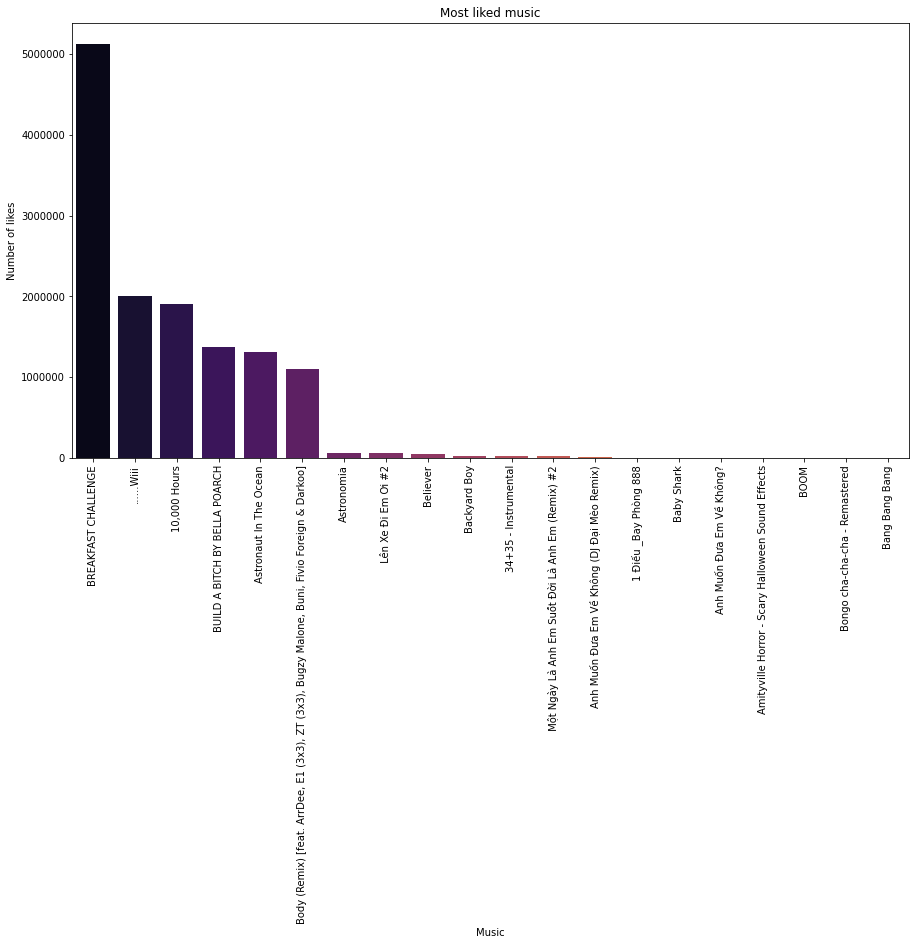

In [43]:
df_filter_dataset = df_filter_dataset.groupby(['musicMeta.musicName']).sum()
pal = sns.color_palette("Blues", as_cmap=True)
 
 
df_music = df_music.sort_values(by='diggCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most liked music')
g = sns.barplot(df_music.index[:20], df_music.diggCount[:20], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.ylabel('Number of likes')
plt.xlabel('Music')

**Top 20 bài hát được phát (play) nhiều nhất**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Music')

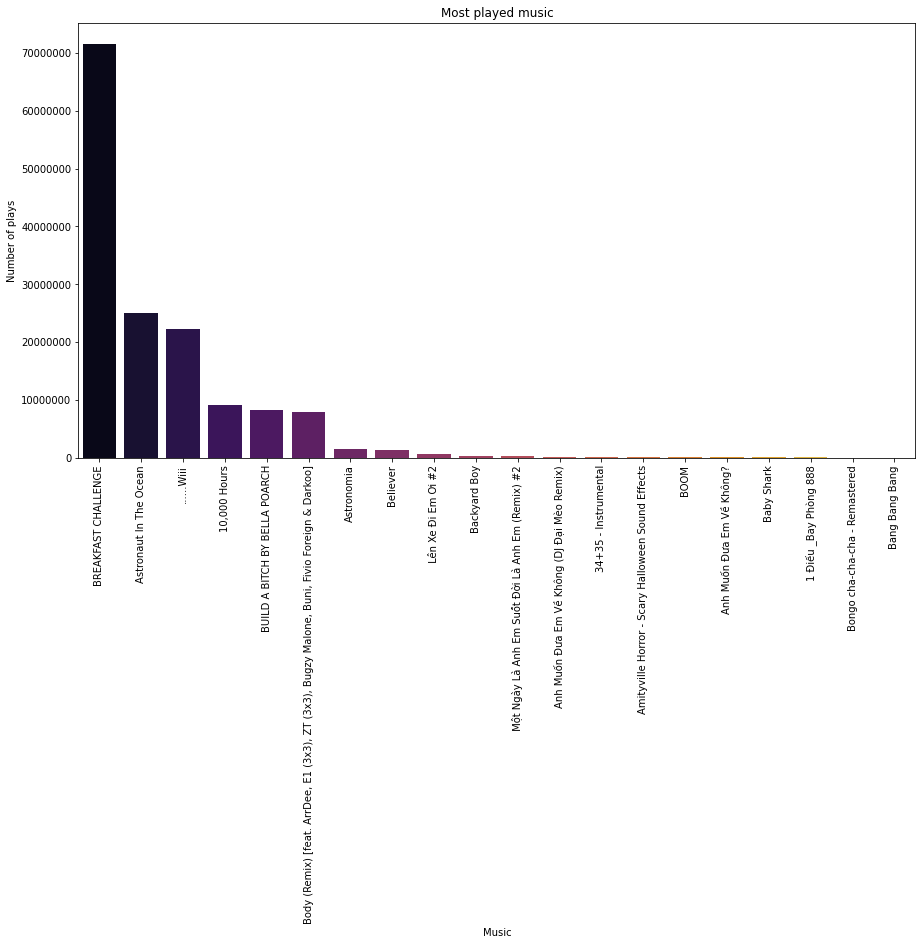

In [44]:
df_filter_dataset = df_filter_dataset.groupby(['musicMeta.musicName']).sum()
pal = sns.color_palette("Blues", as_cmap=True)
 
 
df_music = df_music.sort_values(by='playCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most played music')
g = sns.barplot(df_music.index[:20], df_music.playCount[:20], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
 
plt.ylabel('Number of plays')
plt.xlabel('Music')

**Top 20 video được bình luận nhiều nhất**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Music')

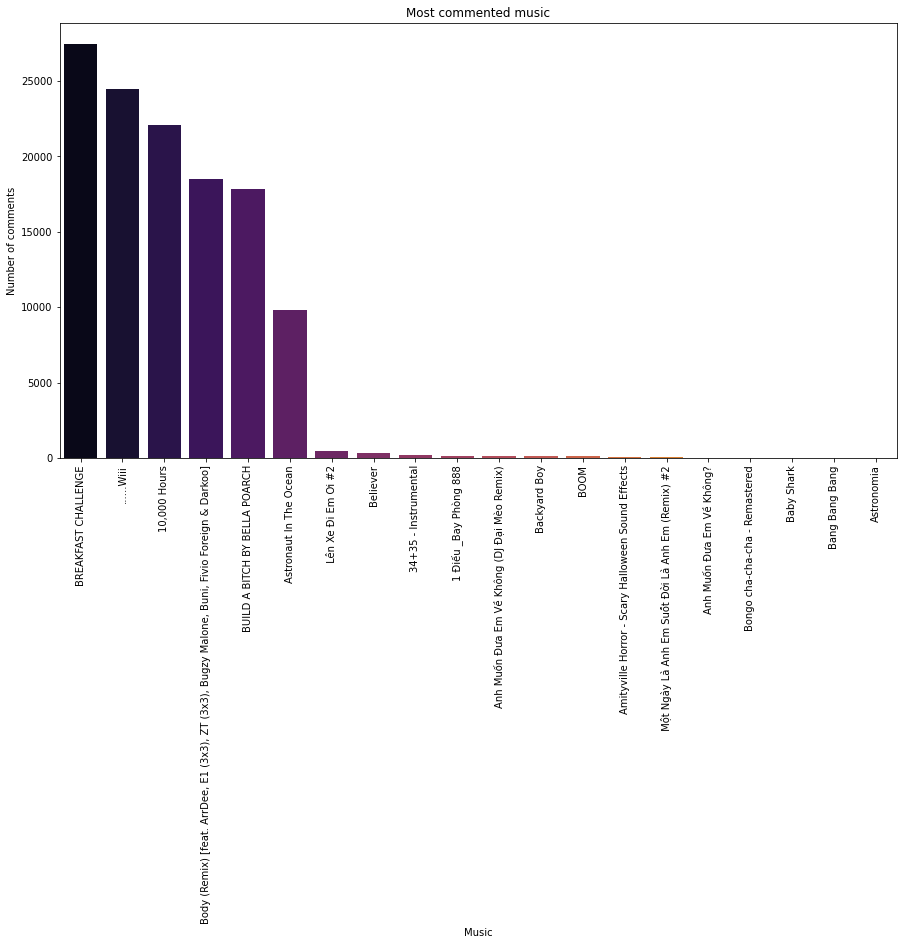

In [45]:
df_filter_dataset = df_filter_dataset.groupby(['musicMeta.musicName']).sum()
pal = sns.color_palette("Blues", as_cmap=True)
 
 
df_music = df_music.sort_values(by='commentCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most commented music')
g = sns.barplot(df_music.index[:20], df_music.commentCount[:20], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
 
plt.ylabel('Number of comments')
plt.xlabel('Music')

**Top 20 video được chia sẻ nhiều nhất**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Music')

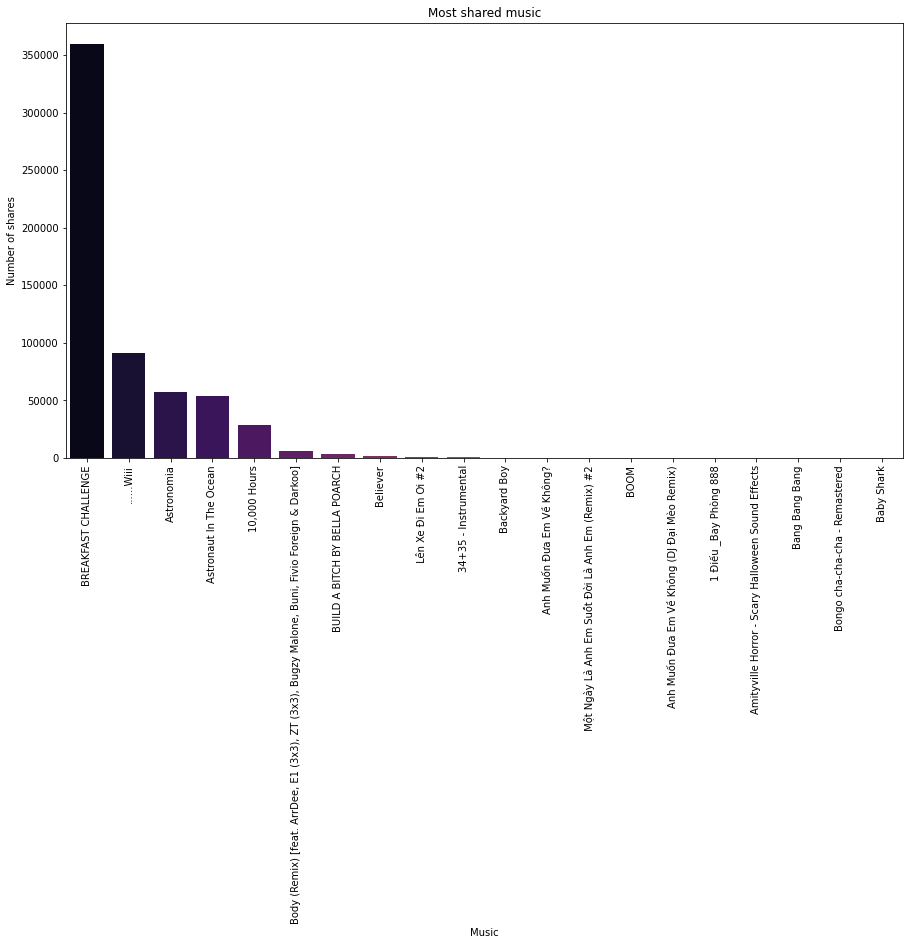

In [46]:
df_filter_dataset = df_filter_dataset.groupby(['musicMeta.musicName']).sum()
pal = sns.color_palette("Blues", as_cmap=True)
 
 
df_music = df_music.sort_values(by='shareCount', ascending=False)
plt.figure(figsize=(15,8))
plt.ticklabel_format(style = 'plain')
plt.title('Most shared music')
g = sns.barplot(df_music.index[:20], df_music.shareCount[:20], palette='inferno')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
 
plt.ylabel('Number of shares')
plt.xlabel('Music')

### **12. Phân tích Hashtag**

In [47]:
df_filter_dataset = df_tiktok_dataset.drop_duplicates(subset=['id'], keep='last')

In [48]:
# expand df.tags into its own dataframe
hashtags = df_filter_dataset['hashtags'].apply(pd.Series)

# rename each variable is tags
hashtags = hashtags.rename(columns = lambda x : 'hashtag_' + str(x))

# view the tags dataframe
hashtags

,hashtag_0,hashtag_1,hashtag_2,hashtag_3,hashtag_4,hashtag_5,hashtag_6,hashtag_7,hashtag_8,hashtag_9,hashtag_10,hashtag_11,hashtag_12,hashtag_13,hashtag_14,hashtag_15,hashtag_16,hashtag_17
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,animals,lion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,nâunngoncungtiktok,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,ceotruongnguyen,hlvtruongnguyen,bandothanhcong,vuotnguong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,gesture,gesturedance,dancer,happy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,fyp,tiktokvn,foryou,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_filter_dataset['hashtags'].describe()

count     578
unique    376
top        []
freq      144
Name: hashtags, dtype: object

In [50]:
hashtags.isnull().sum()

hashtag_0     144
hashtag_1     242
hashtag_2     326
hashtag_3     384
hashtag_4     435
hashtag_5     475
hashtag_6     496
hashtag_7     510
hashtag_8     537
hashtag_9     542
hashtag_10    552
hashtag_11    561
hashtag_12    566
hashtag_13    569
hashtag_14    572
hashtag_15    574
hashtag_16    575
hashtag_17    576
dtype: int64

In [51]:
from google.colab import files
uploaded = files.upload()

Saving tiktok.jpg to tiktok.jpg


In [52]:
from matplotlib import rcParams 
rcParams['figure.figsize']=10,8

In [53]:
lst_hashtag=df_filter_dataset['hashtags'].to_list()
print(lst_hashtag)

[[], [], ['animals', 'lion'], ['nâunngoncungtiktok'], ['ceotruongnguyen', 'hlvtruongnguyen', 'bandothanhcong', 'vuotnguong'], [], [], [], ['phepthuatwinx', 'game', 'xuhuong', 'gamer', 'tiktok', 'xảstress', 'tiktok2021'], ['ceotruongnguyen', 'hlvtruongnguyen', 'bandothanhcong', 'spmedia'], ['funny', 'prank'], [''], ['beautiful', 'scenery', 'travel', 'tiktoker', 'fly'], ['', 'gđ_gk_'], [], ['tiktok', 'fyp', 'moive'], [], ['vietnam', 'nyc', 'vietnam'], ['phepthuatwinx', 'pretzdamdadunggu', 'tiktok2021', 'game', 'tiktok', 'phepthuatwinx', 'xuhuong'], ['dautay', 'cachchamdautay'], ['', 'dúo', 'greenscreen', 'duetos', 'djangelx', 'pircing', 'pircingdelalengua', 'pircings', 'azul', 'blue', 'somalia', '10second', 'fypシ', 'xyzbca', 'maaynor', 'wow'], [], ['foryou', 'cute', 'dog', 'funny', 'pet'], [], ['foryou', 'fyp', 'tiktok'], [], ['smartfurniture', 'furniture', 'spacesaver', 'spacesaving', 'foryou'], ['pottery', 'handmade'], ['despacito', 'luisfonci', 'happyweekend', 'хорошегонастроения', 'д

In [54]:
def read_txt(filename):
  f=open(filename)
  if(f.mode=="r"):
    contents=f.read()
    return contents

In [55]:
stopwords = read_txt("vietnamese-stopwords.txt")

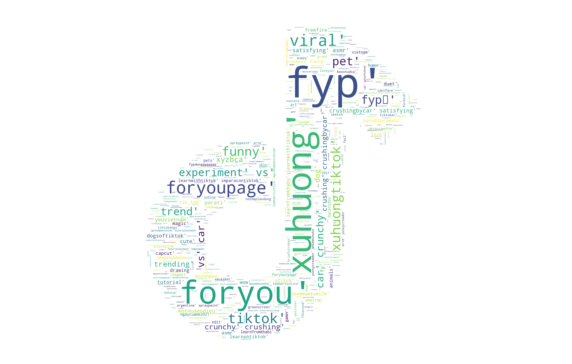

In [56]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np 
from PIL import Image
mask = np.array(Image.open('tiktok.jpg'))
wc = WordCloud(stopwords=STOPWORDS,
               mask=mask, background_color="white",
               max_words=500, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(str(lst_hashtag))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

**HẾT**